## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5rawcomp' #dataset-compression
TRANSFORM = 'cwt-male' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
male_cwt_1e5rawcomp_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os
import sys

sys.path.append('/scratch/users/lievhenry/hierarchical-bayesian-model-validation/utilities')

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

print(os.getcwd())
print(ROOT_DIR)
print(CWD)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

e:\Research\UCB\Strang Lab\Github\hierarchical-bayesian-model-validation\results-audio\case-studies\ravdess\1e5rawcomp\cwt\male
e:\Research\UCB\Strang Lab\Github\hierarchical-bayesian-model-validation
e:\Research\UCB\Strang Lab\Github\hierarchical-bayesian-model-validation\results-audio\case-studies\ravdess\1e5rawcomp\cwt\male


'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5rawcomp\\cwt\\male'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


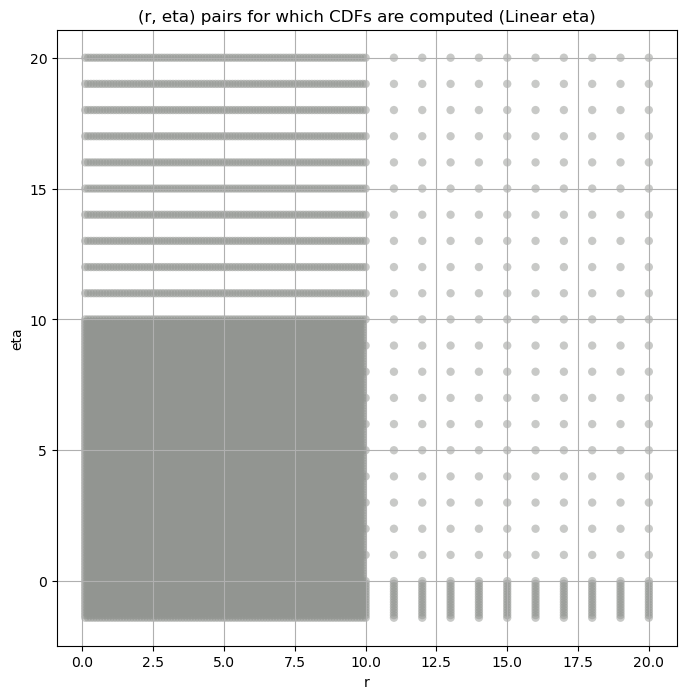

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 18


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 21


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 24


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 27


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 31


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
band,,,,,,,
2,1.822474e+09,1.700371e+09,1.952436e+09,5.210426,4.493137,6.071092,57390260.0
5,2.077598e+09,1.957287e+09,2.201770e+09,3.246958,2.777912,3.765370,57390260.0
8,1.658435e+09,1.562720e+09,1.756838e+09,3.240463,2.820953,3.694844,57390260.0
11,1.349044e+09,1.269734e+09,1.429591e+09,3.330486,2.999298,3.682543,57390260.0
14,2.490594e+08,2.275923e+08,2.715790e+08,9.845651,8.417543,11.466619,57390260.0
18,6.063099e+07,5.545472e+07,6.628828e+07,10.035315,7.303592,14.052322,57390260.0
21,2.765423e+07,2.476906e+07,3.083731e+07,15.866316,11.610804,22.595638,57390260.0
24,1.949298e+07,1.679542e+07,2.245042e+07,29.665370,24.574064,35.520330,57390260.0
27,5.376906e+06,4.510249e+06,6.354094e+06,42.002500,31.563967,57.026110,57390260.0


## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
band,,,,,,,,,,,,
2,1.822474e+09,1.822474e+09,1.788677e+09,1.763098e+09,1.740508e+09,1.719817e+09,1.682243e+09,1.648239e+09,1.616861e+09,1.587546e+09,1.559911e+09,1.484838e+09
5,2.077598e+09,2.077598e+09,2.047802e+09,2.024090e+09,2.002767e+09,1.983016e+09,1.946904e+09,1.914085e+09,1.883756e+09,1.855407e+09,1.828717e+09,1.756368e+09
8,1.658435e+09,1.658435e+09,1.636123e+09,1.617916e+09,1.601670e+09,1.586678e+09,1.559222e+09,1.534192e+09,1.510903e+09,1.488952e+09,1.468102e+09,1.410766e+09
11,1.349044e+09,1.349044e+09,1.334841e+09,1.322305e+09,1.310596e+09,1.299482e+09,1.278574e+09,1.259015e+09,1.240519e+09,1.222904e+09,1.206039e+09,1.159070e+09
14,2.490594e+08,2.490594e+08,2.421528e+08,2.368666e+08,2.322497e+08,2.280610e+08,2.205598e+08,2.138957e+08,2.078448e+08,2.022738e+08,1.970965e+08,1.833799e+08
18,6.063099e+07,6.063099e+07,5.833395e+07,5.683950e+07,5.561661e+07,5.455888e+07,5.276312e+07,5.125068e+07,4.993026e+07,4.875147e+07,4.768330e+07,4.495288e+07
21,2.765423e+07,2.765423e+07,2.632500e+07,2.545046e+07,2.473407e+07,2.411539e+07,2.306898e+07,2.219369e+07,2.143588e+07,2.076501e+07,2.016171e+07,1.864101e+07
24,1.949298e+07,1.949298e+07,1.837702e+07,1.753502e+07,1.681579e+07,1.617850e+07,1.507715e+07,1.414125e+07,1.332546e+07,1.260298e+07,1.195565e+07,1.035018e+07
27,5.376906e+06,5.376906e+06,4.936710e+06,4.646615e+06,4.411480e+06,4.210180e+06,3.874120e+06,3.597784e+06,3.362416e+06,3.157463e+06,2.976338e+06,2.535688e+06


####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.033040537687046734 1822473700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.03248464157921996 1788676900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.033235582709348774 1763098400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.0339087886120836 1740508200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.0345313751103776 1719816600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.035677868093001525 1682243100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.036737294150718136 1648239400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.03652147345485801 1616860500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.035801931813229104 1587546200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.036045120711813414 1559911000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.038620728413417335 1484838100.0
Number of samples: 100000, Without approximation : 57390260.0


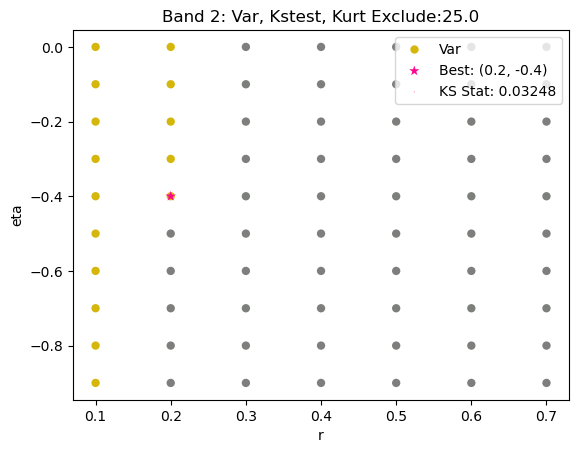

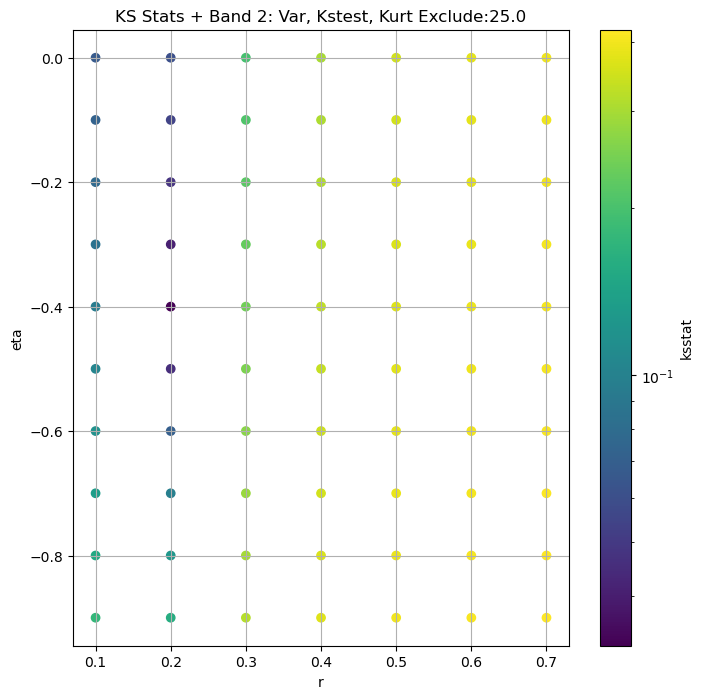

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.026077166449577027 2077597800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.026687968823319294 2047801900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.027421887249025223 2024090500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.027120581207913386 2002767200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.02702202769665711 1983016300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.028252484347479956 1946904200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.027781118438595778 1914085200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.028943692558738354 1883755900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.028660657883233798 1855407400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.02945518026878334 1828717400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.03032062952777631 1756368400.0
Number of samples: 100000, Without approximation : 57390260.0


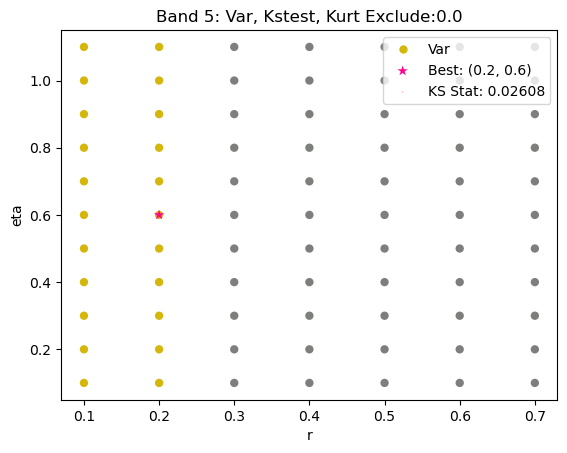

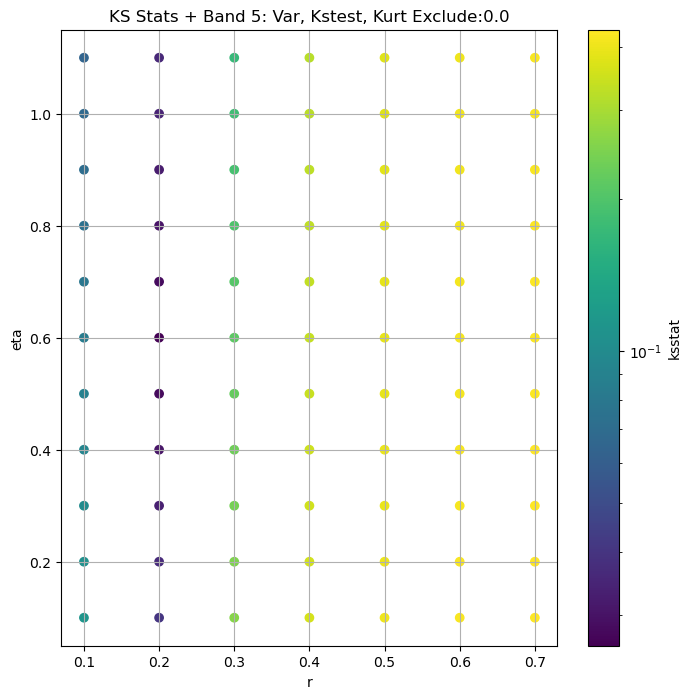

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.02364923063821084 1658434800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.024095406255956187 1636122900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.02490624454997492 1617916400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.024787147319738245 1601670000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.024552647696480745 1586677600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.02535813506204354 1559221600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.025593705104839826 1534192400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.025712952683137363 1510902900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.026612336286159388 1488952400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.026232570543532674 1468101500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.027381656270894172 1410765600.0
Number of samples: 100000, Without approximation : 57390260.0


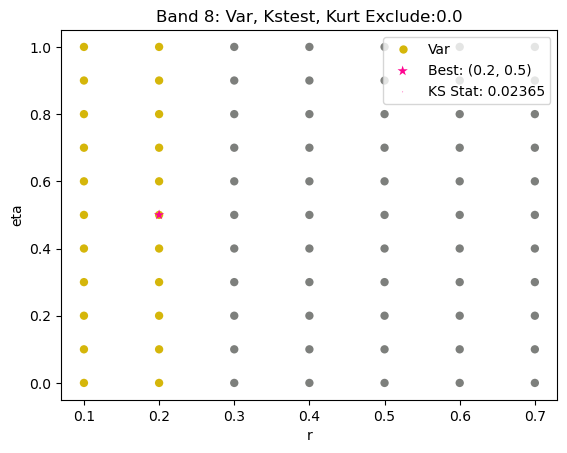

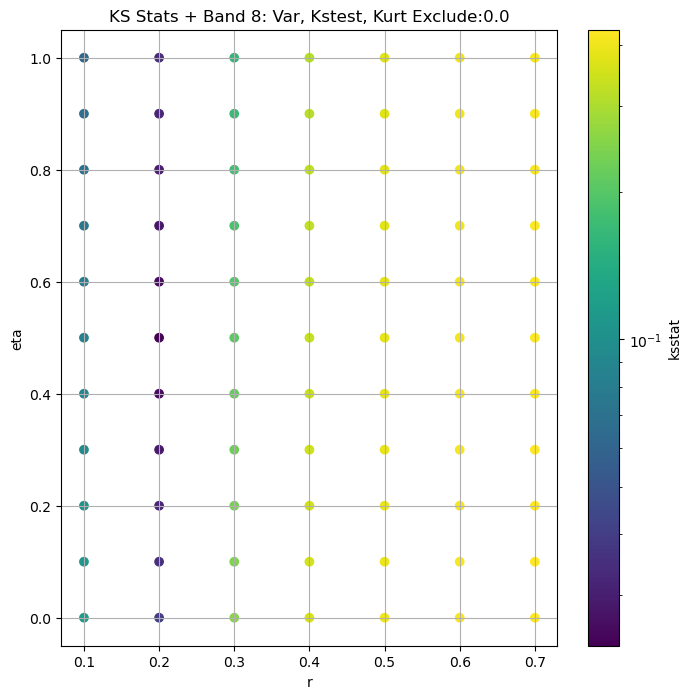

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.03238199857888355 1349044400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.032959351618796026 1334840700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.0334726119593063 1322304900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.033957062757620365 1310596000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.034170698429993596 1299481700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.033597707187127845 1278573600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.03338762263519578 1259014500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.034190200855725814 1240518500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.034962634900307724 1222903900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.03571875653720599 1206038700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.03554129430087864 1159070200.0
Number of samples: 100000, Without approximation : 57390260.0


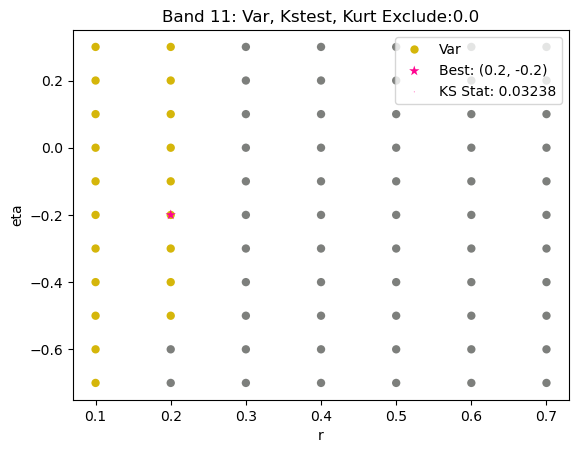

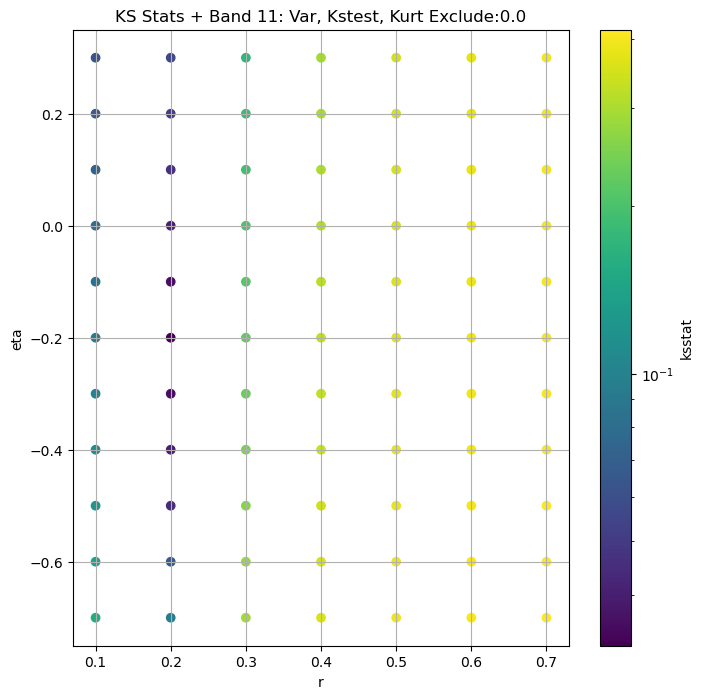

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.02016964635802132 249059410.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.02157360632961325 242152850.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.022680713350697768 236866580.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.023667989006059154 232249700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.023953215892004054 228061040.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.022825998558650973 220559790.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.02287141833177131 213895700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.024290492907441008 207844800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.02564262597162681 202273840.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.026935942542637314 197096510.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.026619410523903486 183379890.0
Number of samples: 100000, Without approximation : 57390260.0


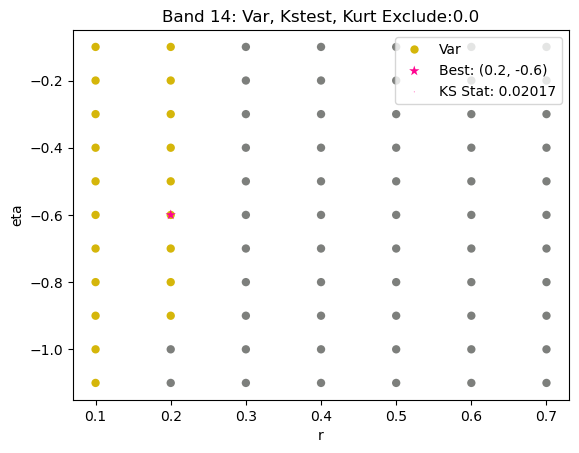

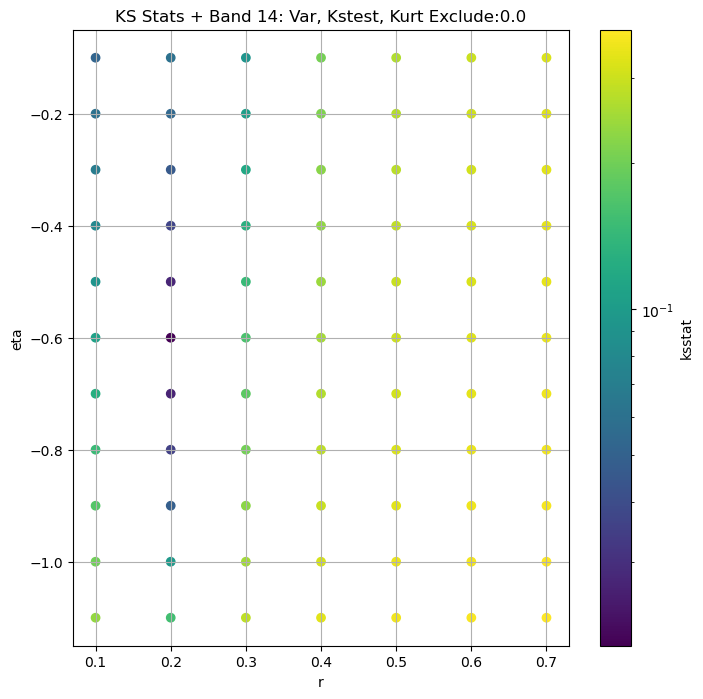

####
Band  18


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 0 0.01893548353392982 60630990.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 25 0.01809855083210421 58333950.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 50 0.019230238279354106 56839504.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 75 0.02045204265628875 55616610.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 100 0.020650898611734192 54558880.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 150 0.020468457240630178 52763120.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 200 0.02207681290135266 51250684.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 250 0.022327034594788464 49930256.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 300 0.022418027000604912 48751468.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 350 0.023629246927732828 47683300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 500 0.024818142476794036 44952884.0
Number of samples: 100000, Without approximation : 57390260.0


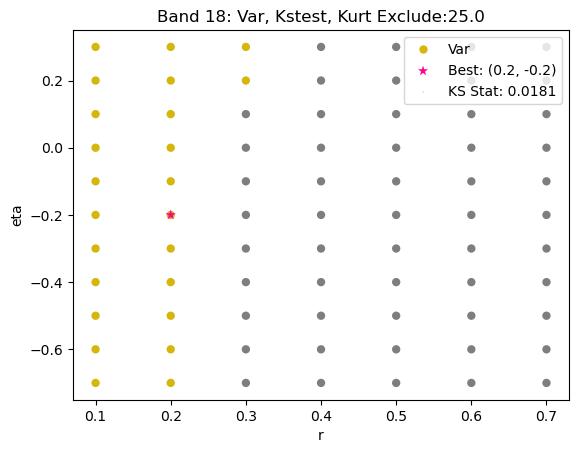

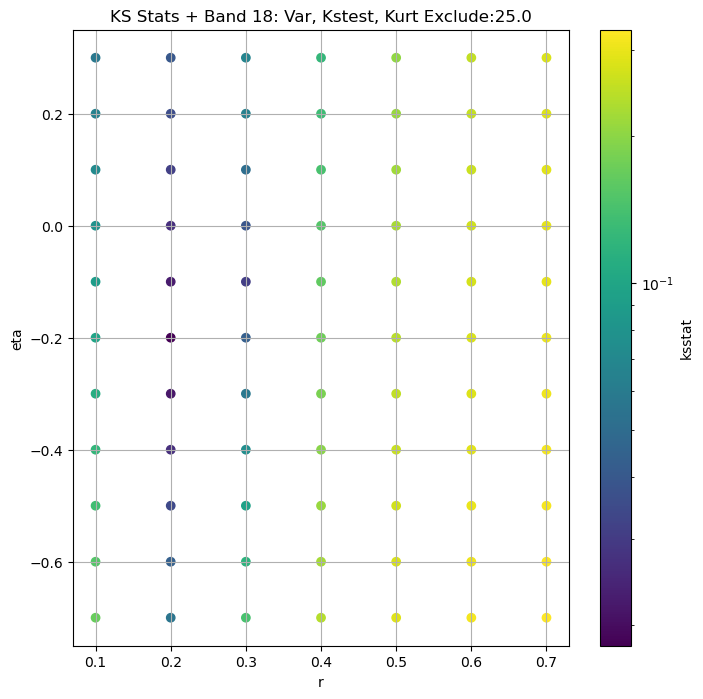

####
Band  21


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 0 0.016266408647460984 27654232.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 25 0.0189681996253086 26324996.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 50 0.018009925762842105 25450456.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 75 0.01722626866664867 24734068.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 100 0.017729487422007223 24115386.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 150 0.020103455945485432 23068984.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 200 0.021764606499150907 22193688.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 250 0.020737949143081136 21435880.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 300 0.021136334672130636 20765010.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 350 0.02268067590917601 20161714.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 500 0.0233055025038722 18641012.0
Number of samples: 100000, Without approximation : 57390260.0


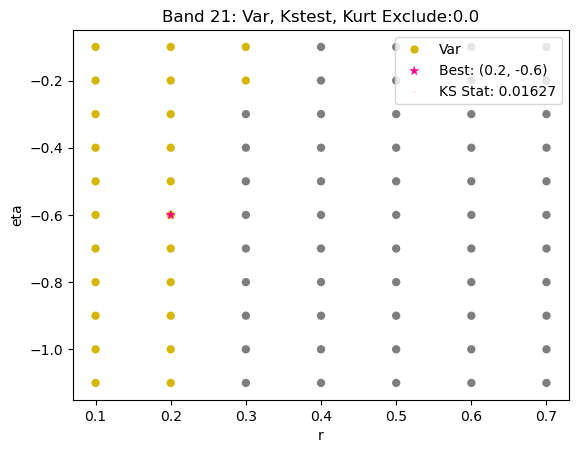

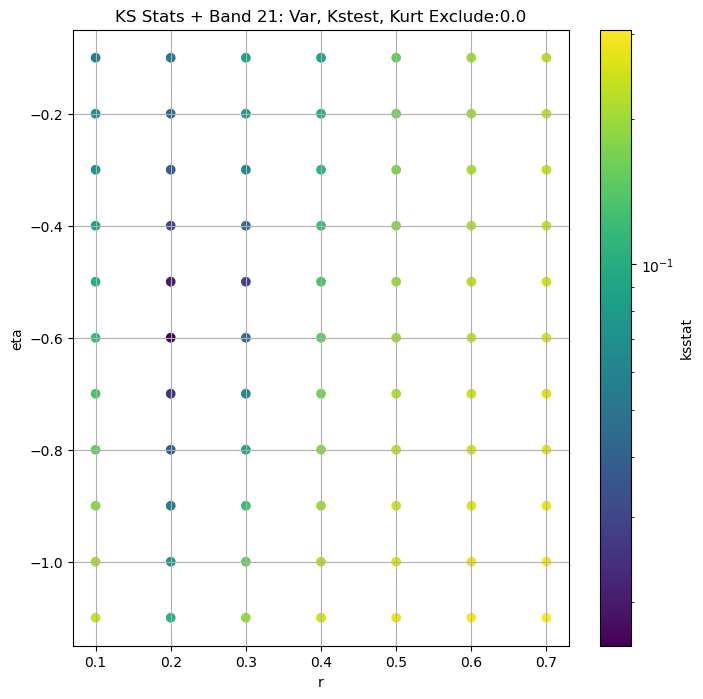

####
Band  24


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 0 0.010967483007785717 19492980.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 25 0.010204044850596256 18377016.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 50 0.007867259310438579 17535024.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 75 0.006759569347037142 16815790.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 100 0.007516833199575523 16178502.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 150 0.009011358182538731 15077146.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 200 0.010467401679457033 14141253.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 250 0.01194092364426514 13325461.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 300 0.013546990489205546 12602980.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 350 0.014898736671534074 11955654.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 500 0.014546976695915315 10350176.0
Number of samples: 100000, Without approximation : 57390260.0


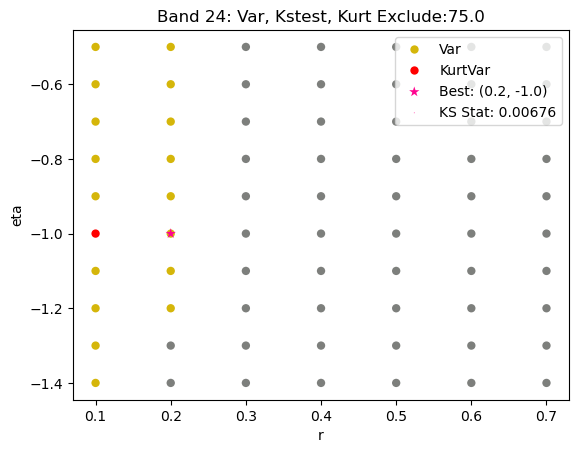

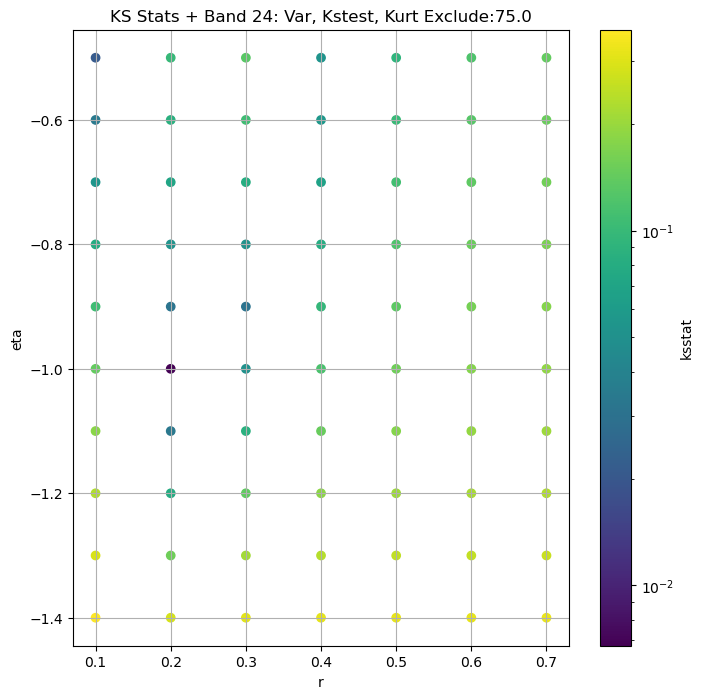

####
Band  27


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 0 0.015918032862000553 5376906.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 25 0.01673828706656635 4936710.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 50 0.01673828706656635 4646615.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 75 0.014723834605822383 4411480.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 100 0.014621975703737022 4210180.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 150 0.014441184397280371 3874120.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 200 0.014287005234279282 3597784.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 250 0.01415092789347494 3362416.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 300 0.014029420446705188 3157462.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 350 0.013921913810852504 2976338.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 500 0.013990355780653607 2535687.5
Number of samples: 100000, Without approximation : 57390260.0


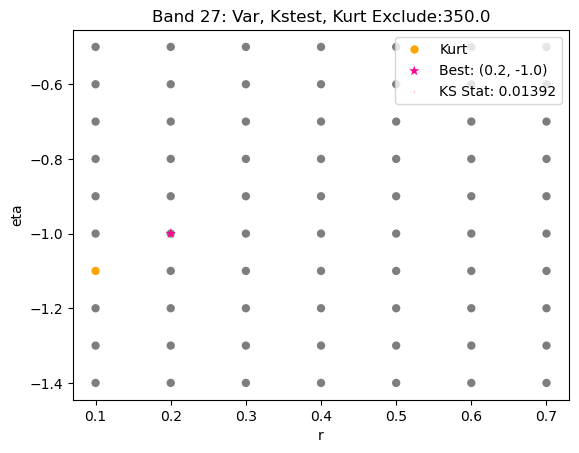

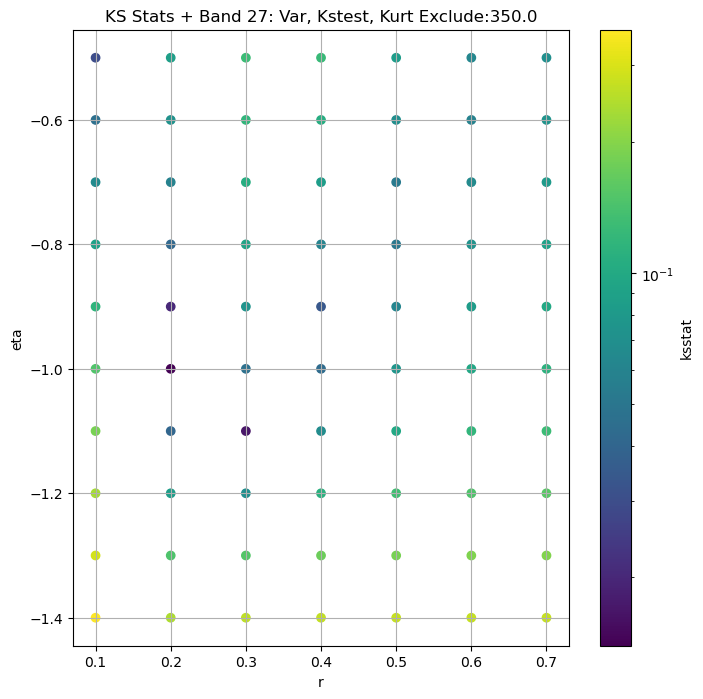

####
Band  31


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 0 0.035755321549444496 164567.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 25 0.035755321549444496 140576.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 50 0.035755321549444496 128443.414


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 75 0.035622836580808726 119291.484


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 100 0.035473578557689456 111854.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 150 0.03556631679341682 100145.33


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 200 0.035271741741994656 91098.74


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 250 0.03499984732390077 83761.99


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 300 0.03474450780336996 77623.62


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 350 0.03450175944569889 72370.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 500 0.035755321549444496 60201.19
Number of samples: 100000, Without approximation : 57390260.0


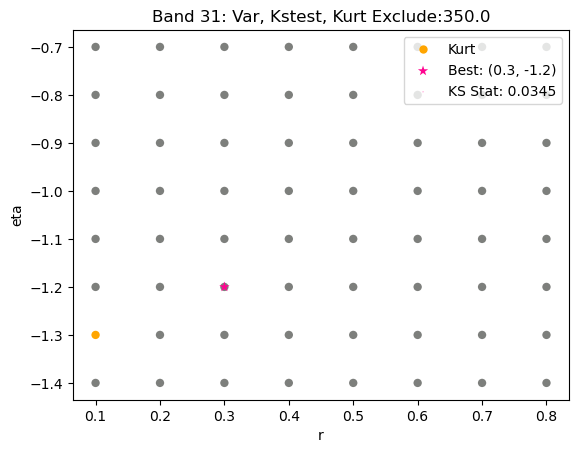

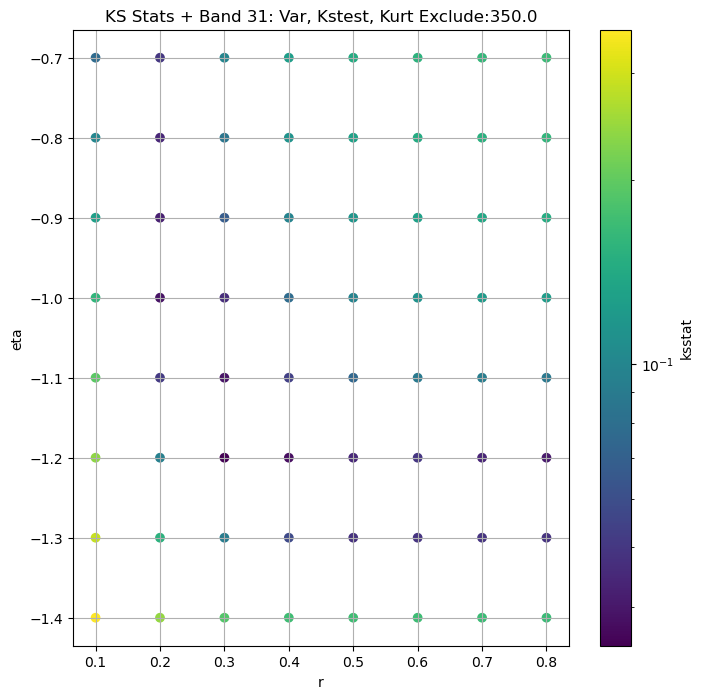

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
band,,,,,,,,,,,,,,
2,1.822474e+09,1.700371e+09,1.952436e+09,5.210426,4.493137,6.071092,57390260.0,0.032485,0.2,-0.4,82613.695394,25.0,1.788677e+09,0.000179
5,2.077598e+09,1.957287e+09,2.201770e+09,3.246958,2.777912,3.765370,57390260.0,0.026077,0.2,0.6,7031.736023,0.0,2.077598e+09,0.000179
8,1.658435e+09,1.562720e+09,1.756838e+09,3.240463,2.820953,3.694844,57390260.0,0.023649,0.2,0.5,6903.241825,0.0,1.658435e+09,0.000179
11,1.349044e+09,1.269734e+09,1.429591e+09,3.330486,2.999298,3.682543,57390260.0,0.032382,0.2,-0.2,32637.717419,0.0,1.349044e+09,0.000179
14,2.490594e+08,2.275923e+08,2.715790e+08,9.845651,8.417543,11.466619,57390260.0,0.020170,0.2,-0.6,24284.781620,0.0,2.490594e+08,0.000179
18,6.063099e+07,5.545472e+07,6.628828e+07,10.035315,7.303592,14.052322,57390260.0,0.018099,0.2,-0.2,1411.285729,25.0,5.833395e+07,0.000179
21,2.765423e+07,2.476906e+07,3.083731e+07,15.866316,11.610804,22.595638,57390260.0,0.016266,0.2,-0.6,2696.452988,0.0,2.765423e+07,0.000179
24,1.949298e+07,1.679542e+07,2.245042e+07,29.665370,24.574064,35.520330,57390260.0,0.006760,0.2,-1.0,11945.949162,75.0,1.681579e+07,0.000179
27,5.376906e+06,4.510249e+06,6.354094e+06,42.002500,31.563967,57.026110,57390260.0,0.013922,0.2,-1.0,2114.392807,350.0,2.976338e+06,0.000179


In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 2, 25.0 + 100 = 125, ksstat: 0.03373875396502313, var: 1700491520.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 2, 25.0 + 75 = 100, ksstat: 0.03338612617725295, var: 1719816576.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 2, 25.0 + 50 = 75, ksstat: 0.03313713642283424, var: 1740508160.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 2, 25.0 + 25 = 50, ksstat: 0.032846498769056875, var: 1763098368.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 2, 25.0 + 0 = 25, ksstat: 0.03248464157921996, var: 1788676864.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 2, 25.0 + -25 = 0, ksstat: 0.03215875918324851, var: 1822473728.0
Number of samples: 100000, Without approximation : 57390260.0


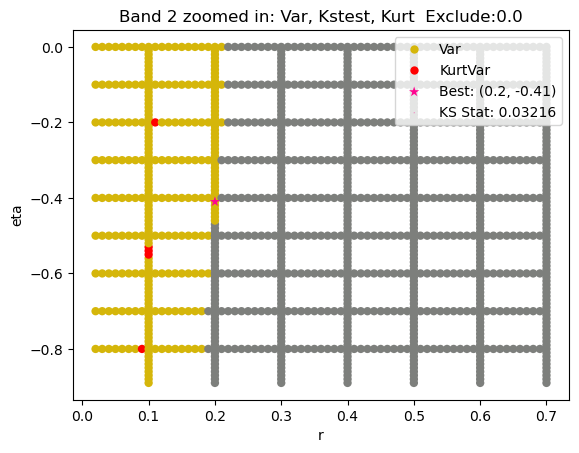

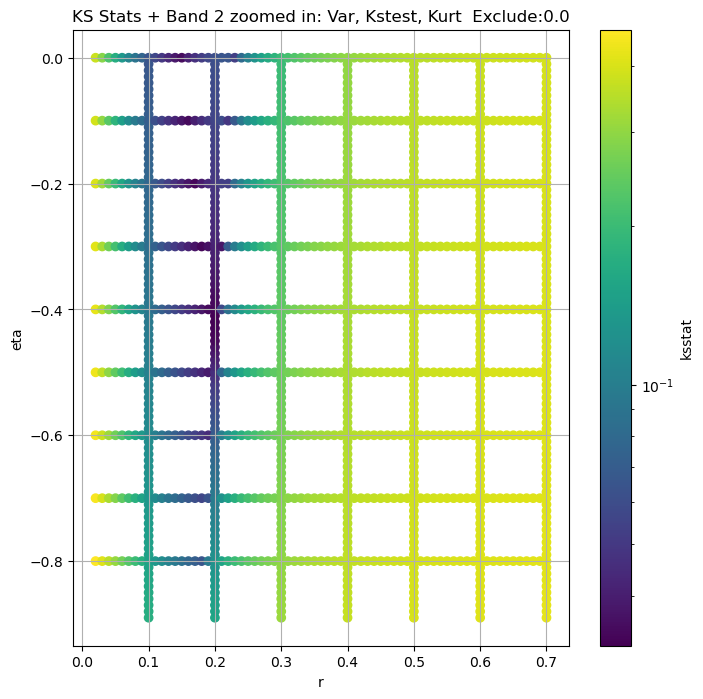

Band 5


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 5, 0.0 + 100 = 100, ksstat: 0.026332853850121296, var: 1983016320.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 5, 0.0 + 75 = 75, ksstat: 0.02661391866368945, var: 2002767232.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 5, 0.0 + 50 = 50, ksstat: 0.026913183788491224, var: 2024090496.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 5, 0.0 + 25 = 25, ksstat: 0.026167536723657042, var: 2047801856.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 5, 0.0 + 0 = 0, ksstat: 0.02572471853883307, var: 2077597824.0
Number of samples: 100000, Without approximation : 57390260.0


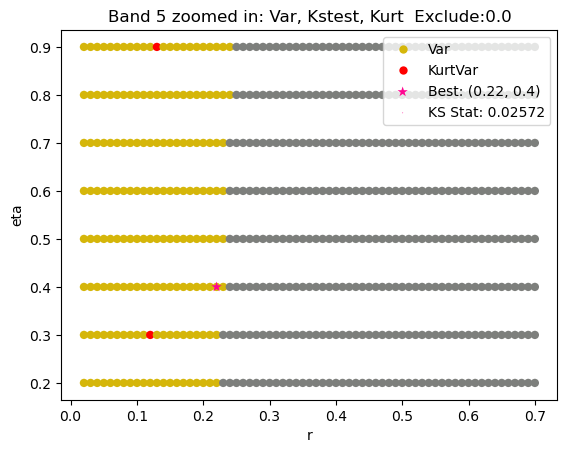

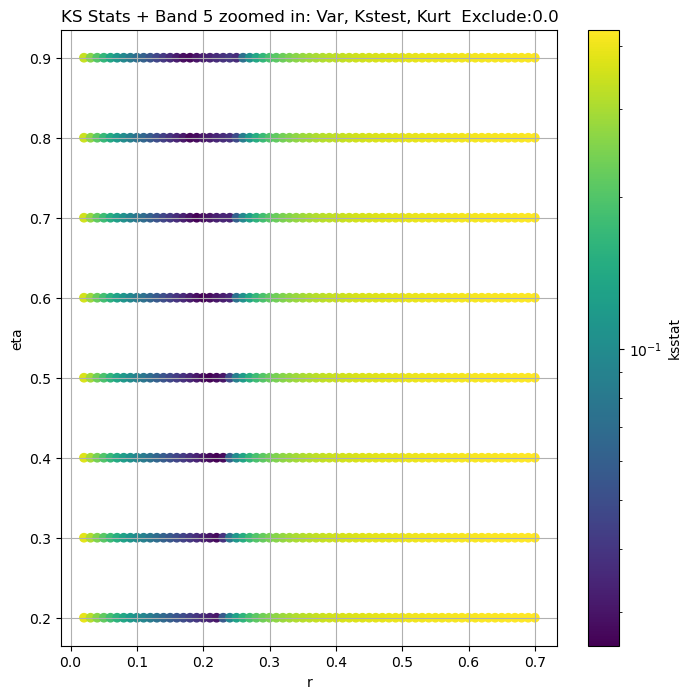

Band 8


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 0.0 + 100 = 100, ksstat: 0.02375176622905889, var: 1586677632.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 0.0 + 75 = 75, ksstat: 0.023972319859591862, var: 1601670016.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 0.0 + 50 = 50, ksstat: 0.024217485010428863, var: 1617916416.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 0.0 + 25 = 25, ksstat: 0.023781905613841747, var: 1636122880.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 0.0 + 0 = 0, ksstat: 0.02309093370283566, var: 1658434816.0
Number of samples: 100000, Without approximation : 57390260.0


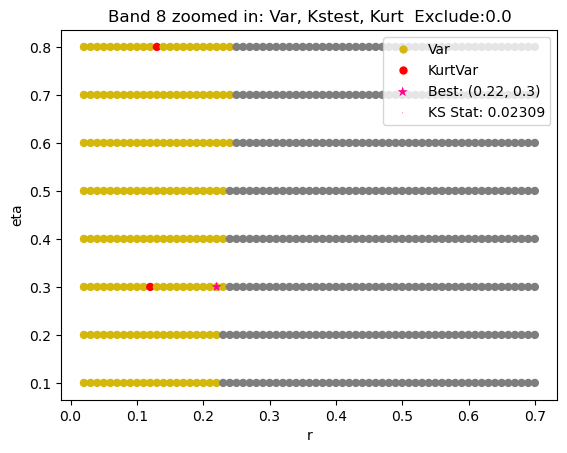

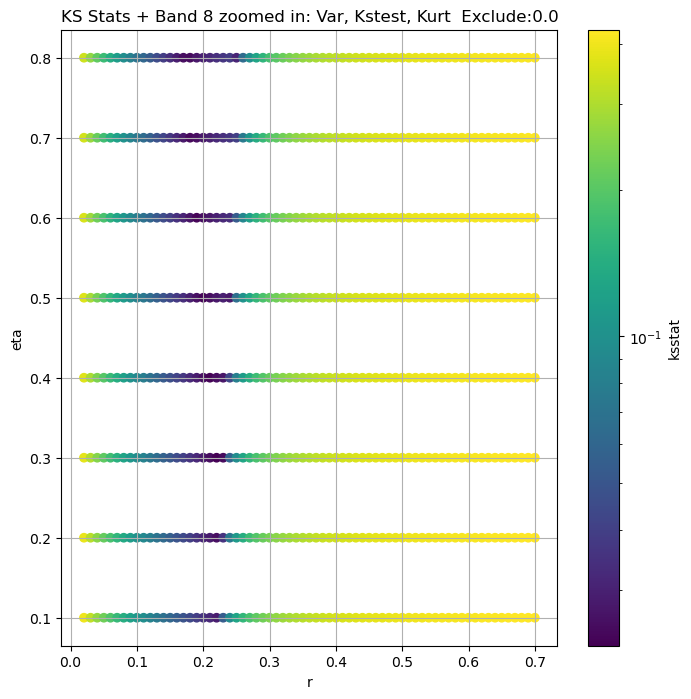

Band 11


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 11, 0.0 + 100 = 100, ksstat: 0.032165854068415434, var: 1299481728.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 11, 0.0 + 75 = 75, ksstat: 0.032255670209274334, var: 1310595968.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 11, 0.0 + 50 = 50, ksstat: 0.03203947335982303, var: 1322304896.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 11, 0.0 + 25 = 25, ksstat: 0.031803386697049615, var: 1334840704.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 11, 0.0 + 0 = 0, ksstat: 0.031541061004959514, var: 1349044352.0
Number of samples: 100000, Without approximation : 57390260.0


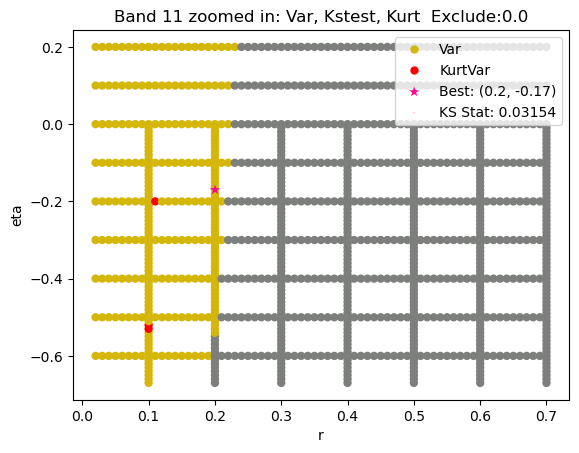

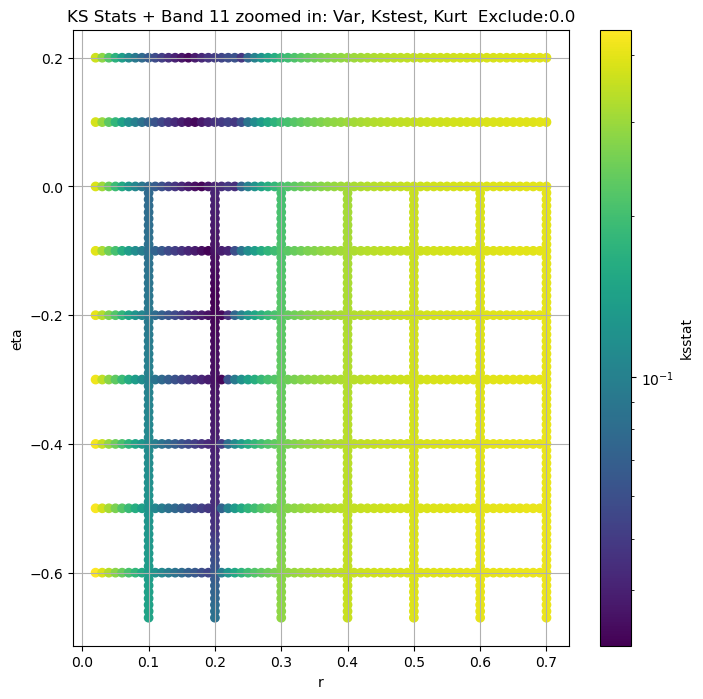

Band 14


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 0.0 + 100 = 100, ksstat: 0.021122747028481548, var: 228061040.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 0.0 + 75 = 75, ksstat: 0.020572391147817393, var: 232249696.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 0.0 + 50 = 50, ksstat: 0.01979839433331937, var: 236866576.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 0.0 + 25 = 25, ksstat: 0.019983850320092422, var: 242152848.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 0.0 + 0 = 0, ksstat: 0.01909992572753272, var: 249059408.0
Number of samples: 100000, Without approximation : 57390260.0


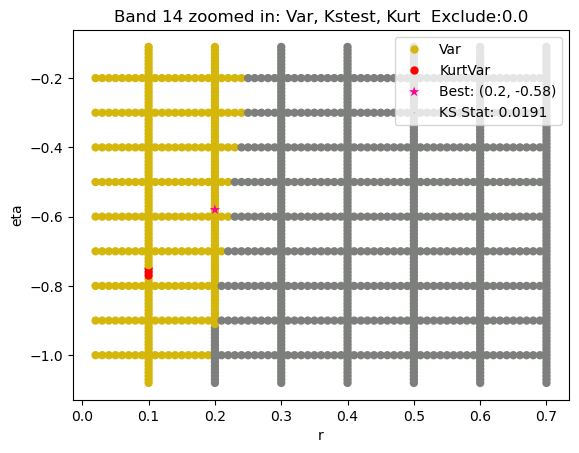

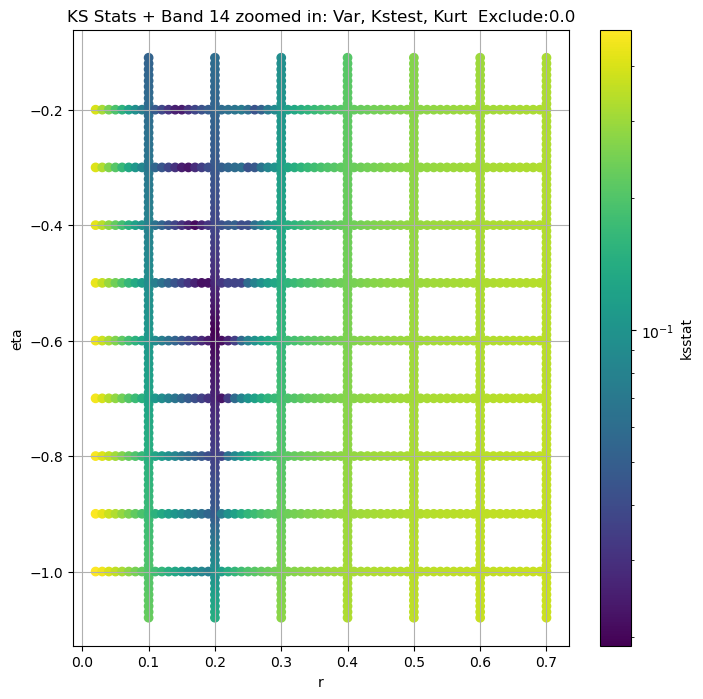

Band 18


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 25.0 + 100 = 125, ksstat: 0.01839985642163211, var: 53617056.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 25.0 + 75 = 100, ksstat: 0.01855694186280754, var: 54558880.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 25.0 + 50 = 75, ksstat: 0.017820704928580122, var: 55616608.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 25.0 + 25 = 50, ksstat: 0.0176640166775337, var: 56839504.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 25.0 + 0 = 25, ksstat: 0.01678805655359561, var: 58333952.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 25.0 + -25 = 0, ksstat: 0.015812722705886406, var: 60630992.0
Number of samples: 100000, Without approximation : 57390260.0


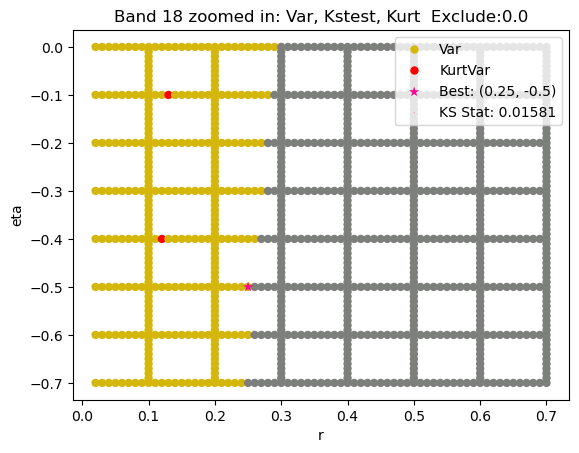

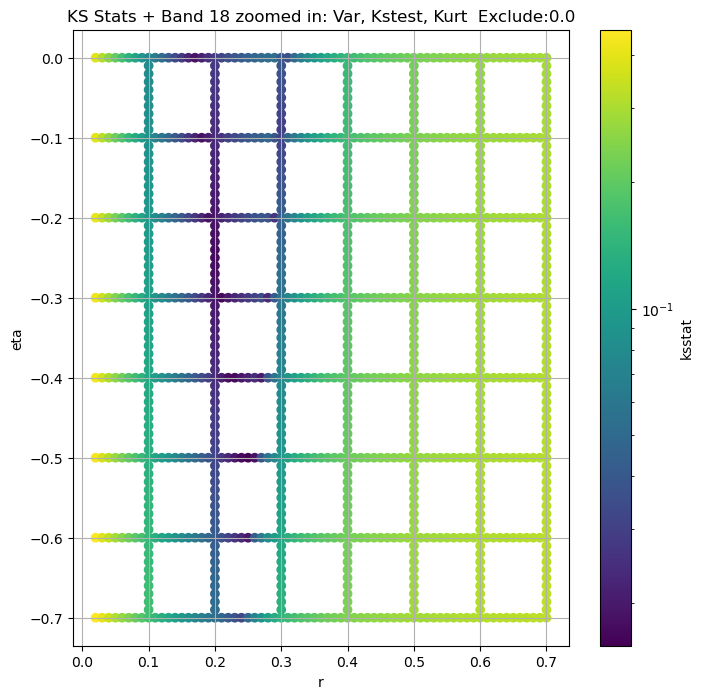

Band 21


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 100 = 100, ksstat: 0.015310381032430986, var: 24115386.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 75 = 75, ksstat: 0.015583771698962759, var: 24734068.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 50 = 50, ksstat: 0.014069157328518891, var: 25450456.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 25 = 25, ksstat: 0.014654484709559323, var: 26324996.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 0 = 0, ksstat: 0.012787348148459055, var: 27654232.0
Number of samples: 100000, Without approximation : 57390260.0


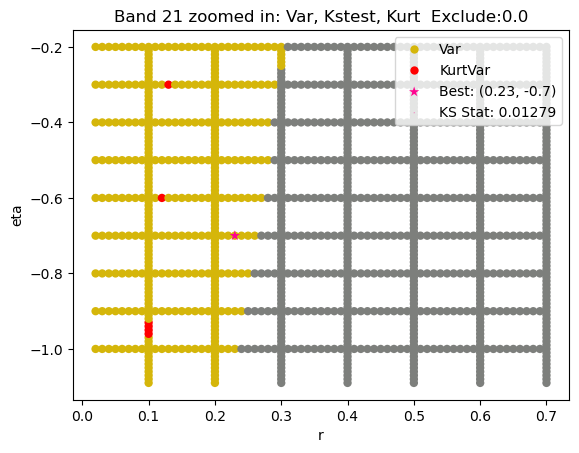

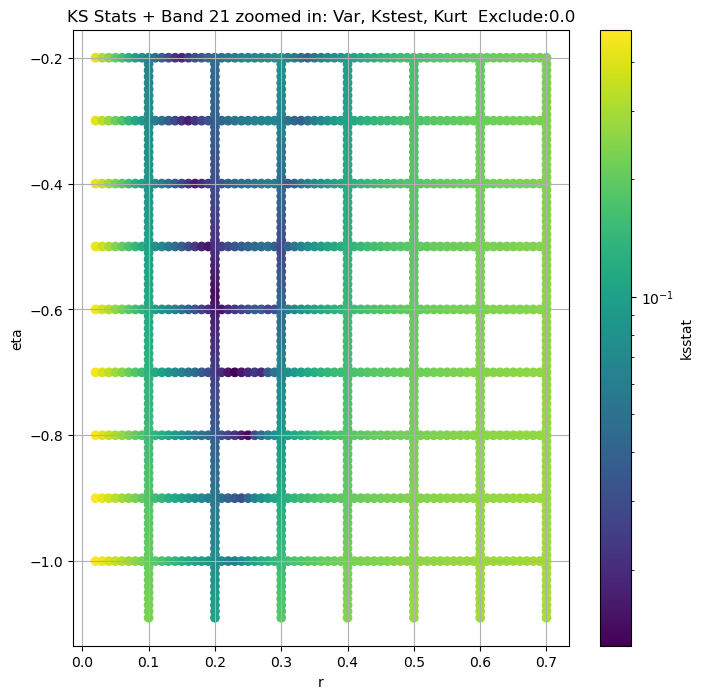

Band 24


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 75.0 + 100 = 175, ksstat: 0.00844334238382416, var: 14591879.0


  0%|          | 0/1223 [00:00<?, ?it/s]

In [ ]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

In [ ]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [ ]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [ ]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

## Results

In [ ]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [ ]:
master_df.filter(regex="kstest_stat.*")

In [ ]:
master_df.filter(regex="best.*")